Because creating a fully-fledged CNN would require many more samples than are at our disposal, a highly simplified 3-class CNN was created to explore how a CNN classification tool might be an effective and more wholeistic avenue for determining adulteration within maple syrups and juices. As a disclaimer: this CNN is simply a proof of concept and not intended to be a rigorous demonstration. It has problems with overfitting to the small sample size and (in part due to this) is sensitive to class imbalances which can tend it at times to solely classify into the majority class. 

After importing all the needed libraries. I used splitfolders to create a more random train/validation/test split of 70/15/15 percents respectively. splitfolders was also used because as of yet, "ImageDataGenerator()" has no tri-split option. Preparing to use "ImageDataGenerator()" and "flow_from_directory", I established separate directories to refer to. 

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import scipy as sp
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
import math
import sklearn
from sklearn import metrics
import splitfolders 

input_folder = r"C:\Users\maiaz\Desktop\Dark Auto Sets\3 Class Bulk"
output_folder= r"C:\Users\maiaz\Desktop\Dark Auto Sets\3 Class Split"

splitfolders.ratio(input_folder, output= output_folder, ratio = (0.7, 0.15, 0.15))

train_data_dir = r"C:\Users\maiaz\Desktop\Dark Auto Sets\3 Class Split\train"
test_data_dir = r"C:\Users\maiaz\Desktop\Dark Auto Sets\3 Class Split\test"
val_data_dir = r"C:\Users\maiaz\Desktop\Dark Auto Sets\3 Class Split\val"

In image width and batch size were set, corresponding to the 86x86 pixel images created with "CNN Preprosessing." The parameters of "ImageDataGenerator" were set with the 3-channel images being rescaled. Width, height, and zoom shifts of 5% were added, and horizontal image reflections were allowed. This discourages network overfitting and simulates having more data than actually available. 

In [7]:
img_width, img_height = 86, 86
batch_size = 30

train_datagen = ImageDataGenerator(
rescale=1./255,
width_shift_range=.05,
height_shift_range=.05,
zoom_range=0.05,
horizontal_flip=True)

test_datagen = ImageDataGenerator(
rescale=1./255)

Here the three datasets are actually established. The train and validation sets had shuffling enabled, while the test did not. The class_mode is set to "categorical" because I planned to use "CategoricalCrossEntropy" as my model optimizer.

In [8]:
#data augmentation
train_ds = train_datagen.flow_from_directory(
train_data_dir,
shuffle=True,
target_size=(img_width, img_height),
batch_size=batch_size,
class_mode='categorical')

valid_ds = train_datagen.flow_from_directory(
val_data_dir,
shuffle=True,
target_size=(img_width, img_height),
batch_size=batch_size,
class_mode='categorical')

test_ds= test_datagen.flow_from_directory(
test_data_dir,
target_size=(img_width, img_height),
batch_size=batch_size,
class_mode='categorical',
shuffle=False)

Found 213 images belonging to 3 classes.
Found 44 images belonging to 3 classes.
Found 49 images belonging to 3 classes.


Finally, we create and train the model. The number of hidden layers were chosen by trial and error and probably don't reflect what the architecture of a "final" model would be. The learning rate was brought down to .0001 to improve accuracy, and as with the ANN, "EarlyStopping" was used to reduce overtraining the model (which is also why the number of epochs is set to 1000).

In [10]:
#THE MODEL
cnn = Sequential()

cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=(img_width,img_height,3)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Flatten())

cnn.add(Dense(32, activation='relu'))
cnn.add(Dense(3, activation='softmax'))

optimizer = keras.optimizers.Adam(learning_rate=.0001)
cnn.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=optimizer,
              metrics=['accuracy'])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

epochs=1000

history = cnn.fit(
  train_ds,
  validation_data=valid_ds,
  steps_per_epoch=math.ceil(len(train_ds) / batch_size),
  epochs=epochs,
  callbacks=[es])

Epoch 1/1000
1/1 [==============================] - 1s 1s/step - loss: 1.1152 - accuracy: 0.2667 - val_loss: 1.0861 - val_accuracy: 0.3864
Epoch 2/1000
1/1 [==============================] - 0s 329ms/step - loss: 1.1066 - accuracy: 0.2333 - val_loss: 1.0583 - val_accuracy: 0.3864
Epoch 3/1000
1/1 [==============================] - 0s 374ms/step - loss: 1.0609 - accuracy: 0.3333 - val_loss: 1.0498 - val_accuracy: 0.3636
Epoch 4/1000
1/1 [==============================] - 0s 193ms/step - loss: 0.9032 - accuracy: 0.6667 - val_loss: 1.0553 - val_accuracy: 0.3636
Epoch 5/1000
1/1 [==============================] - 0s 282ms/step - loss: 1.0626 - accuracy: 0.3000 - val_loss: 1.0597 - val_accuracy: 0.4318
Epoch 6/1000
1/1 [==============================] - 0s 357ms/step - loss: 1.0382 - accuracy: 0.4333 - val_loss: 1.0603 - val_accuracy: 0.4773
Epoch 7/1000
1/1 [==============================] - 0s 343ms/step - loss: 1.0930 - accuracy: 0.4667 - val_loss: 1.0359 - val_accuracy: 0.5682
Epoch 8/1

1/1 [==============================] - 0s 272ms/step - loss: 0.6366 - accuracy: 0.8000 - val_loss: 0.6108 - val_accuracy: 0.7273
Epoch 59/1000
1/1 [==============================] - 0s 277ms/step - loss: 0.7072 - accuracy: 0.7000 - val_loss: 0.6484 - val_accuracy: 0.6818
Epoch 60/1000
1/1 [==============================] - 0s 257ms/step - loss: 0.5833 - accuracy: 0.6667 - val_loss: 0.6204 - val_accuracy: 0.6818
Epoch 61/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.5066 - accuracy: 0.7667 - val_loss: 0.6044 - val_accuracy: 0.7500
Epoch 62/1000
1/1 [==============================] - 0s 333ms/step - loss: 0.5599 - accuracy: 0.8333 - val_loss: 0.6256 - val_accuracy: 0.7273
Epoch 63/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.8584 - accuracy: 0.3333 - val_loss: 0.6051 - val_accuracy: 0.7955
Epoch 64/1000
1/1 [==============================] - 0s 310ms/step - loss: 0.5935 - accuracy: 0.7333 - val_loss: 0.6297 - val_accuracy: 0.7500
Epoch 65/1000

1/1 [==============================] - 0s 223ms/step - loss: 0.3103 - accuracy: 1.0000 - val_loss: 0.5034 - val_accuracy: 0.7955
Epoch 116/1000
1/1 [==============================] - 0s 317ms/step - loss: 0.3916 - accuracy: 0.8333 - val_loss: 0.5124 - val_accuracy: 0.7727
Epoch 117/1000
1/1 [==============================] - 0s 266ms/step - loss: 0.5151 - accuracy: 0.7667 - val_loss: 0.5211 - val_accuracy: 0.8182
Epoch 118/1000
1/1 [==============================] - 0s 341ms/step - loss: 0.4636 - accuracy: 0.8000 - val_loss: 0.5228 - val_accuracy: 0.7273
Epoch 119/1000
1/1 [==============================] - 0s 331ms/step - loss: 0.5451 - accuracy: 0.7000 - val_loss: 0.4757 - val_accuracy: 0.7273
Epoch 120/1000
1/1 [==============================] - 0s 307ms/step - loss: 0.5728 - accuracy: 0.7333 - val_loss: 0.4771 - val_accuracy: 0.8409
Epoch 121/1000
1/1 [==============================] - 0s 265ms/step - loss: 0.6263 - accuracy: 0.7667 - val_loss: 0.5322 - val_accuracy: 0.7727
Epoch 1

We plot the loss functions and show the average accuracy and loss for the training, validation, and test sets.

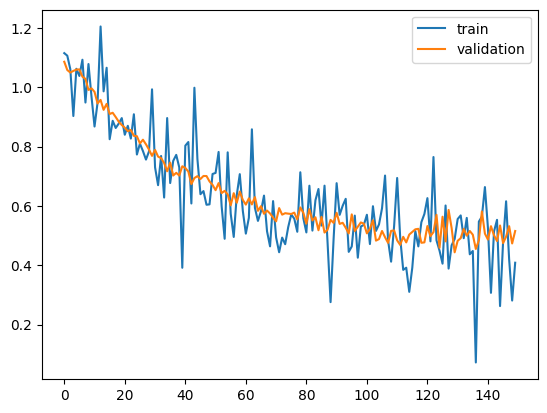

2/2 [==============================] - 0s 39ms/step - loss: 0.5592 - accuracy: 0.7273
[0.5592394471168518, 0.7272727489471436]
8/8 [==============================] - 1s 66ms/step - loss: 0.5179 - accuracy: 0.7887
[0.5178859829902649, 0.7887324094772339]
2/2 [==============================] - 0s 65ms/step - loss: 0.6116 - accuracy: 0.7551
[0.6116371750831604, 0.7551020383834839]


In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

print(cnn.evaluate(valid_ds))
print(cnn.evaluate(train_ds))
print(cnn.evaluate(test_ds))

Here we create a confusion matrix and classification report to show which classes performed better (rather than an average) which can be misleading. 

In [12]:
test_steps_per_epoch = np.math.ceil(test_ds.samples / test_ds.batch_size)
predictions = cnn.predict(test_ds, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions,axis=1)
true_classes = test_ds.classes
class_labels = list(test_ds.class_indices.keys())   
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)  
confusion=metrics.confusion_matrix(true_classes,predicted_classes)
print(confusion)

2/2 [==============================] - 0s 11ms/step
              precision    recall  f1-score   support

 10 and over       1.00      0.38      0.55        16
 5 and under       0.57      1.00      0.73        16
        Dark       1.00      0.88      0.94        17

    accuracy                           0.76        49
   macro avg       0.86      0.75      0.74        49
weighted avg       0.86      0.76      0.74        49

[[ 6 10  0]
 [ 0 16  0]
 [ 0  2 15]]


The following shows feature maps for a sample image in the training set. The feature map shows that the CNN is primarily learning from the actual EEMs rather than unrelated noise and artifacts within the images. Note that the code for feature visualization is NOT my own and was pulled from https://github.com/arshren/Feature-Visualization.

conv2d_3 (3, 3, 3, 32)
0 conv2d_3 (None, 84, 84, 32)
1/1 [==============================] - 0s 59ms/step
(1, 42, 42, 32)
(1, 56448)
(1, 32)
(1, 3)


C:\Users\maiaz\AppData\Local\Temp\ipykernel_7508\935675795.py:43: RuntimeWarning: invalid value encountered in divide
  x /= x.std ()


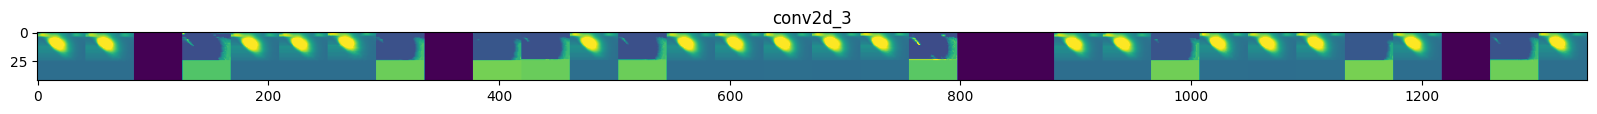

In [13]:
#Filter shape
for layer in cnn.layers:
    if 'conv' not in layer.name:
        continue    
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)

#size of output
for i in range(len(cnn.layers)):
    layer = cnn.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)

#Feature map visualization code from https://github.com/arshren/Feature-Visualization
from tensorflow.keras.models import Model
successive_outputs = [layer.output for layer in cnn.layers[1:]]
visualization_model = Model(inputs = cnn.input, outputs = successive_outputs)
img_path = r"C:\Users\maiaz\Desktop\Dark Auto Sets\3 Class Bulk\10 and over\DrMCD6 (7).png"
img = keras.utils.load_img(img_path, target_size=(86, 86))
x = keras.utils.img_to_array(img)                           
x = x.reshape((1,) + x.shape)
x /= 255.0

successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in cnn.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
        
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )
